Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


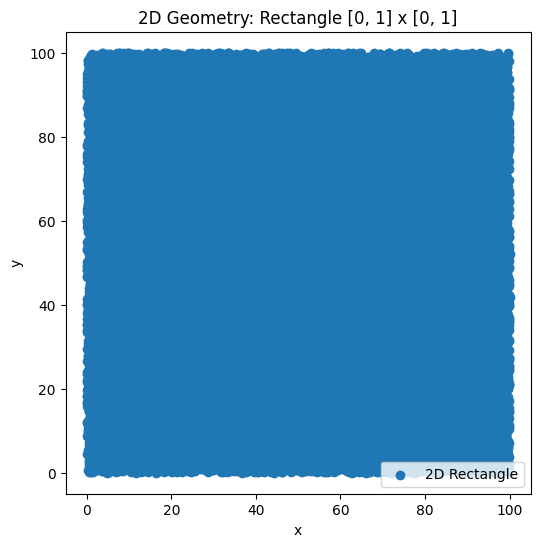

Compiling model...
'compile' took 0.880376 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [0.00e+00, 5.84e+13, 2.16e+00, 7.72e+00]    [0.00e+00, 5.84e+13, 2.16e+00, 7.72e+00]    []  
1000      [0.00e+00, 7.84e+10, 2.88e-06, 7.73e-06]    [0.00e+00, 7.84e+10, 2.88e-06, 7.73e-06]    []  
2000      [0.00e+00, 4.76e+10, 4.67e-05, 1.14e-04]    [0.00e+00, 4.76e+10, 4.67e-05, 1.14e-04]    []  
3000      [0.00e+00, 4.98e+10, 1.50e-06, 3.23e-06]    [0.00e+00, 4.98e+10, 1.50e-06, 3.23e-06]    []  
4000      [0.00e+00, 3.88e+09, 1.62e-07, 3.67e-08]    [0.00e+00, 3.88e+09, 1.62e-07, 3.67e-08]    []  
5000      [0.00e+00, 2.79e+09, 2.60e-07, 3.37e-07]    [0.00e+00, 2.79e+09, 2.60e-07, 3.37e-07]    []  
6000      [0.00e+00, 7.11e+08, 8.81e-07, 2.55e-06]    [0.00e+00, 7.11e+08, 8.81e-07, 2.55e-06]    []  
7000      [0.00e+00, 1.34e+08, 6.03e-07, 1.74e-06]    [0.00e+00, 1.34e+08, 6.03e-07, 1.74e-06]    []  
8

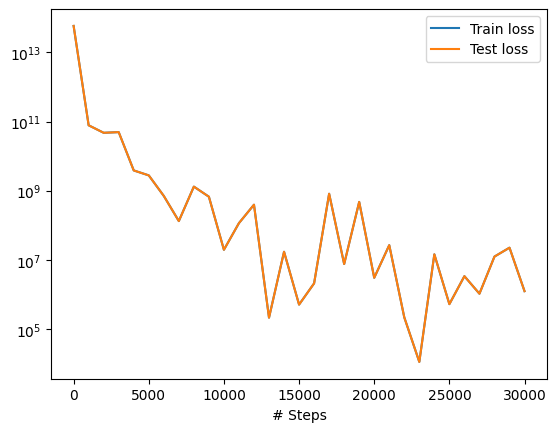

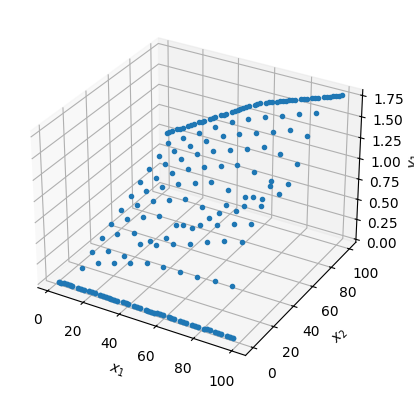

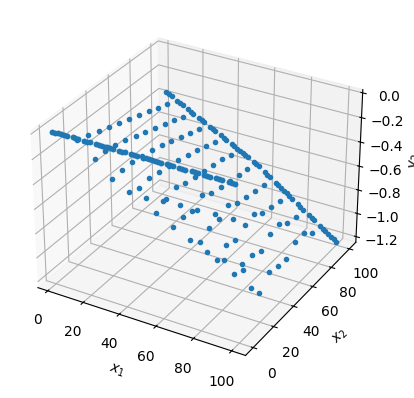

In [1]:
import pandas as pd
import os
import tensorflow as tf
import torch
os.environ['DDE_BACKEND'] = 'pytorch'
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

traction=1e5 
E=2e8
L =100 # mm
nu=0.3
qx=0
qy=0
square = dde.geometry.Rectangle([0, 0], [L, L])
geom = square


# Sample points in the geometry
Samp = geom.random_points(30000)

# Visualize the geometry
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)
def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)



def traction_top(x, y,X):
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u_x/∂x
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u_x/∂y
    duydx = dde.grad.jacobian(y, x, i=1, j=0)  # ∂u_y/∂x
    duydy = dde.grad.jacobian(y, x, i=1, j=1)  # ∂u_y/∂y

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on top boundary
    T_x = sigma_xy  # Since n_x = 0, T_x = σ_xy n_y
    T_y = sigma_yy  # Since n_y = 1, T_y = σ_yy n_y

    # Desired traction
    T_x_desired = 0
    T_y_desired = traction  # 1e5 Pa
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired    

    return torch.stack([T_x_residual, T_y_residual], dim=-1)


bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma=dde.OperatorBC(geom, traction_top, boundary_top)


def pde(x, y):
    
    duxdx=dde.grad.jacobian(y,x,i=0,j=0)
    duxdy=dde.grad.jacobian(y,x,i=0,j=1)
    duydx=dde.grad.jacobian(y,x,i=1,j=0)
    duydy=dde.grad.jacobian(y,x,i=1,j=1)
    #Strain
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Constitutive relations residuals
    sigma_xx = (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy
    
    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0)
    sigma_xy_y = dde.grad.jacobian(sigma_xy, x, i=0, j=1)
    sigma_xy_x = dde.grad.jacobian(sigma_xy, x, i=0, j=0)
    sigma_yy_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    
    return torch.stack([eq1, eq2], dim=-1)

data = dde.data.PDE(
    geom,
    pde, [bc_top_sigma, bc_bottom_u_x, bc_bottom_u_y],
    num_domain=300,
    num_boundary=200,
    num_test=100,
    )

# Network for C_L
layer_size = [2] + [62] * 5 + [2]  
activation = "relu"
initializer = "He Uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)

model= dde.Model(data, net_C_L)

model.compile("adam", lr=1e-4)
# Define the model with the PDE, initial and boundary conditions

# Add the callback when training the model
losshistory, train_state = model.train(epochs=30000, display_every=1000)

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)